# Machine Learning Applications for Health (COMP90089_2022_SM2)
# Group Assignment: Digital Phenotype of Diabetes Mellitus.

### Group members
- Mukhammad Karimov - mkarimov@student.unimelb.edu.au - 1019332
- Ching Yin Wan - chingyin@student.unimelb.edu.au - 1371446
- Youran Zhou - youran@student.unimelb.edu.au - 991504
- Kartik Mahendra Jalal - jalalk@student.unimelb.edu.au - 1311994

This notebook assumes that you have access to MIMIC-IV on Google BigQuery.

### **Goals**

Propose a digital pheonotype for **diabetes mellitus**, describe ways to identify a patient cohort with MIMIC-IV using the diagnosis criteria, apply different machine learning approaches, and compare and contrast the metrics.

### **Definitions**

Disease: Diabetes mellitus.

According to UpToDate, diabetes mellitus refers to 'diseases of abnormal carbohydrate metabolism that are characterized by hyperglycemia.' It is related to impaired insulin secretion and peripheral resistance to insulin action.

Disease criteria source: [Diabetes: Diagnosis of diabetes mellitus or prediabetes in non-pregnant adults](https://www.uptodate.com/contents/clinical-presentation-diagnosis-and-initial-evaluation-of-diabetes-mellitus-in-adults)

### Install necessary libraries: Google Colab does not have the InterpretML library installed, so the following command needs to be run.

In [ ]:
pip install interpret

### Load libraries and set up the environment

In [ ]:
# Import libraries
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, roc_curve, auc, roc_auc_score, classification_report

from interpret import set_visualize_provider, show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.provider import InlineProvider

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Access data with Google BigQuery
from google.colab import auth
from google.cloud import bigquery


To query MIMIC-IV, authenticate this notebook with the Google Cloud Platform using a Google account that has been granted access to MIMIC-IV via PhysioNet.

In [ ]:
# Authenticate
auth.authenticate_user()

Set up the project ID by pasting the one you have from BigQuery into the code below.

In [ ]:
# Set up environment variables
project_id = "clinical-entity-extraction"
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes
def run_query(query, project_id = project_id):
    return pd.io.gbq.read_gbq(query, project_id = project_id, dialect = "standard")

## Diagnosis for diabetes mellitus

Patients with diabetes mellitus have either symptomatic or asymptomatic hyperglycemia. The diagnosis criteria for the two kinds of hyperglycemia are listed as follows:

**Symptomatic hyperglycemia**


1.    Exhibition of thirst, polyuria, weight loss, or blurry vision → **Not applicable**: MIMIC-IV does not contain any information regarding these symptoms.


2.   Random blood glucose values $\ge$ 200 mg/dL → **Not applicable**: MIMIC-IV does not contain items related to random blood glucose values.


**Asymptomatic hyperglycemia**



1.   FPG values $\ge$ 126 mg/dL → **Not applicable**: MIMIC-IV does not contain any information regarding FPG values.
2.   Two-hour plasma glucose values $\ge$ 200 mg/dL during a 75g OGTT → **Indirectly applicable**: MIMIC-IV does not contain items directly related to plasma glucose, but it does contain items for blood glucose.
3.   A1C values $\ge$ 6.5% → **Applicable**: MIMIC-IV contains items for A1C values.


## Items for finalized diagnosis criteria

Given that MIMIC-IV could not be used to determine whether a patient has symptomatic hyperglycemia, only asymptomatic hyperglycemia should be considered. Blood glucose and A1C values would be used to perform digital phenotyping. The items that would be used from MIMIC-IV for doing so are listed below:

### Blood glucose values:
1. Table: d_labitems
*   Glucose: itemid = 50809
*   Glucose: itemid = 50931
2. Table: d_items
*   Glucose (whole blood): itemid = 226537

### A1C values:
1. Table: d_labitems
*   % Hemoglobin A1c: itemid = 50852

## MIMIC-IV exploration: Number of occurrences of each selected item

In [ ]:
query = """SELECT itemid, COUNT(*) AS Frequency FROM `physionet-data.mimiciv_hosp.labevents`
WHERE itemid IN (50809, 50931, 50852)
GROUP BY itemid
UNION ALL
SELECT itemid, COUNT(*) AS Frequency FROM `physionet-data.mimiciv_icu.chartevents`
WHERE itemid = 226537
GROUP BY itemid;"""

result = run_query(query)
result

,itemid,Frequency
0,226537,156736
1,50852,235348
2,50809,221767
3,50931,2893059


## MIMIC-IV exploration: Number of unique patients from each selected item

In [ ]:
query = """SELECT itemid, COUNT(DISTINCT(subject_id)) AS Patients FROM `physionet-data.mimiciv_hosp.labevents`
WHERE ((itemid = 50809 OR itemid = 50931) AND (valuenum >= 200)) OR ((itemid = 50852) AND (valuenum >= 6.5))
GROUP BY itemid
UNION ALL
SELECT itemid, COUNT(DISTINCT(subject_id)) AS Patients FROM `physionet-data.mimiciv_icu.chartevents`
WHERE (itemid = 226537) AND (valuenum >= 200)
GROUP BY itemid;"""

result = run_query(query)
result

,itemid,Patients
0,226537,5571
1,50852,22013
2,50931,40232
3,50809,10444


## Data collection

In [ ]:
# Module: mimiciv_hosp
# Table: labevents

query = """SELECT subject_id, valuenum AS glucose_amount FROM `physionet-data.mimiciv_hosp.labevents`
WHERE (itemid = 50809 OR itemid = 50931) AND (valuenum >= 200);"""

glucose_hosp = run_query(query)
glucose_hosp

,subject_id,glucose_amount
0,10108480,316.0
1,10128111,270.0
2,10227155,350.0
3,10270064,303.0
4,10297774,289.0
...,...,...
268226,18434727,255.0
268227,18754359,255.0
268228,18852216,255.0
268229,18962557,255.0


[1]: 
https://www.uptodate.com/contents/clinical-presentation-diagnosis-and-initial-evaluation-of-diabetes-mellitus-in-adults?search=diabetes%20mellitus&source=search_result&selectedTitle=1~150&usage_type=default&display_rank=1#H3

In [ ]:
# Module: mimiciv_hosp
# Table: labevents

query = """SELECT subject_id, valuenum AS a1c_amount FROM `physionet-data.mimiciv_hosp.labevents`
WHERE (itemid = 50852) AND (valuenum >= 6.5);"""

a1c_hosp = run_query(query)
a1c_hosp

,subject_id,a1c_amount
0,10030753,11.6
1,10030753,10.8
2,10152997,10.9
3,10250304,14.9
4,10367718,15.4
...,...,...
90201,17090246,10.4
90202,18646253,10.4
90203,18902344,10.4
90204,11042045,10.4



[1]: https://www.uptodate.com/contents/clinical-presentation-diagnosis-and-initial-evaluation-of-diabetes-mellitus-in-adults?search=diabetes%20mellitus&source=search_result&selectedTitle=1~150&usage_type=default&display_rank=1#H3

In [ ]:
# Module: mimiciv_icu
# Table: chartevents

query = """SELECT subject_id, valuenum AS glucose_amount FROM `physionet-data.mimiciv_icu.chartevents`
WHERE (itemid = 226537) AND (valuenum >= 200);"""

glucose_icu = run_query(query)
glucose_icu

,subject_id,glucose_amount
0,17455762,228.0
1,18118203,225.0
2,16785014,203.0
3,17536222,200.0
4,10538657,291.0
...,...,...
13917,11151240,320.0
13918,11917664,217.0
13919,14901524,207.0
13920,12003679,241.0


In [ ]:
glucose = pd.concat([glucose_icu, glucose_hosp])
glucose

,subject_id,glucose_amount
0,17455762,228.0
1,18118203,225.0
2,16785014,203.0
3,17536222,200.0
4,10538657,291.0
...,...,...
268226,18434727,255.0
268227,18754359,255.0
268228,18852216,255.0
268229,18962557,255.0


In [ ]:
patient_cohort = pd.merge(glucose, a1c_hosp, how = "inner", left_on = "subject_id", right_on = "subject_id")
patient_cohort

,subject_id,glucose_amount,a1c_amount
0,17455762,228.0,11.4
1,17455762,244.0,11.4
2,17455762,390.0,11.4
3,17455762,332.0,11.4
4,17455762,277.0,11.4
...,...,...,...
1210400,16985138,255.0,6.7
1210401,16985138,255.0,7.2
1210402,16985138,255.0,7.7
1210403,18303020,255.0,7.2


## Feature engineering

Create the following features:



1.   Mean blood glucose value
2.   Mean A1C value


In [ ]:
patient_cohort_gb = patient_cohort.groupby(by = "subject_id")

patient_id = [i for i, g in patient_cohort_gb]
patient_glucose_mean = [g["glucose_amount"].mean() for i, g in patient_cohort_gb]
patient_a1c_mean = [g["a1c_amount"].mean() for i, g in patient_cohort_gb]

patient_cohort_mean = pd.DataFrame({"patient_id": patient_id, "mean_glucose": patient_glucose_mean, "mean_a1c": patient_a1c_mean})
patient_cohort_mean.head()

,patient_id,mean_glucose,mean_a1c
0,10000980,266.222222,7.180000
1,10001122,247.500000,8.500000
2,10001877,205.000000,7.700000
3,10002013,313.573770,8.857895
4,10002976,278.333333,10.400000


## Obtain information on the mortality rate

In [ ]:
query = "SELECT * FROM `physionet-data.mimiciv_hosp.patients`;"

death = run_query(query)
death

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10078138,F,18,2110,2017 - 2019,NaT
1,10180372,M,18,2110,2008 - 2010,NaT
2,10686175,M,18,2110,2011 - 2013,NaT
3,10851602,F,18,2110,2014 - 2016,NaT
4,10902424,F,18,2110,2017 - 2019,NaT
...,...,...,...,...,...,...
315455,11965764,F,59,2208,2014 - 2016,NaT
315456,14476240,F,64,2208,2014 - 2016,NaT
315457,17217407,F,68,2208,2014 - 2016,NaT
315458,18539655,M,69,2208,2014 - 2016,NaT


In [ ]:
# Obtain a dataset containing information on patient mortality, mean blood glucose values and mean A1C values
merged_death = pd.merge(death, patient_cohort_mean, how = "inner", left_on = "subject_id", right_on = "patient_id")
merged_death

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,patient_id,mean_glucose,mean_a1c
0,15689743,M,21,2110,2011 - 2013,NaT,15689743,237.000000,10.90
1,14456100,M,22,2110,2011 - 2013,NaT,14456100,333.000000,9.60
2,10008454,F,26,2110,2011 - 2013,NaT,10008454,223.625000,7.10
3,12343415,M,28,2110,2011 - 2013,NaT,12343415,242.000000,7.70
4,10950807,M,29,2110,2017 - 2019,NaT,10950807,299.000000,9.00
...,...,...,...,...,...,...,...,...,...
16346,11973788,F,71,2206,2011 - 2013,NaT,11973788,278.666667,7.92
16347,18802748,M,46,2207,2014 - 2016,NaT,18802748,269.125000,8.80
16348,13774741,F,91,2207,2014 - 2016,2211-02-27,13774741,224.000000,6.90
16349,13899008,F,91,2207,2014 - 2016,2207-08-09,13899008,203.000000,6.90


In [ ]:
dead_patient = merged_death[merged_death["dod"].notna()]
print(f"Mortality rate: {100 * dead_patient.shape[0] / merged_death.shape[0]}%")

Mortality rate: 24.022995535441257%


In [ ]:
# Create an indicator that lists each patient as alive (0) or dead (1)
merged_death["label"] = merged_death["dod"].where(merged_death["dod"].isnull(), 1).fillna(0).astype(int)
merged_death

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,patient_id,mean_glucose,mean_a1c,label
0,15689743,M,21,2110,2011 - 2013,NaT,15689743,237.000000,10.90,0
1,14456100,M,22,2110,2011 - 2013,NaT,14456100,333.000000,9.60,0
2,10008454,F,26,2110,2011 - 2013,NaT,10008454,223.625000,7.10,0
3,12343415,M,28,2110,2011 - 2013,NaT,12343415,242.000000,7.70,0
4,10950807,M,29,2110,2017 - 2019,NaT,10950807,299.000000,9.00,0
...,...,...,...,...,...,...,...,...,...,...
16346,11973788,F,71,2206,2011 - 2013,NaT,11973788,278.666667,7.92,0
16347,18802748,M,46,2207,2014 - 2016,NaT,18802748,269.125000,8.80,0
16348,13774741,F,91,2207,2014 - 2016,2211-02-27,13774741,224.000000,6.90,1
16349,13899008,F,91,2207,2014 - 2016,2207-08-09,13899008,203.000000,6.90,1


## Feature extraction

In [ ]:
query = "SELECT * FROM `physionet-data.mimiciv_hosp.admissions`;"

admissions = run_query(query)
admissions

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,None,UNKNOWN,NaT,NaT,1
1,10017531,20668418,2158-01-20 16:52:00,2158-01-30 14:30:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,None,WHITE,NaT,NaT,0
2,10017531,21095812,2159-12-26 20:14:00,2160-02-04 16:00:00,NaT,URGENT,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,None,WHITE,NaT,NaT,0
3,10017531,22580355,2159-09-22 19:30:00,2159-10-24 13:40:00,NaT,URGENT,TRANSFER FROM HOSPITAL,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,None,WHITE,NaT,NaT,0
4,10021312,25020332,2113-08-16 00:32:00,2113-08-18 17:35:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,None,UNKNOWN,NaT,NaT,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454319,19979081,25032257,2179-02-20 07:15:00,2179-02-27 16:45:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,DIVORCED,ASIAN - CHINESE,NaT,NaT,0
454320,19991135,28088185,2124-02-17 08:30:00,2124-02-20 08:50:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,DIVORCED,WHITE,NaT,NaT,0
454321,19995012,29185936,2153-04-11 13:00:00,2153-04-14 13:51:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Other,ENGLISH,DIVORCED,BLACK/AFRICAN AMERICAN,NaT,NaT,0
454322,19995790,22970553,2185-02-02 12:00:00,2185-02-06 17:08:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Medicare,ENGLISH,DIVORCED,WHITE,NaT,NaT,0


## Feature engineering

Create the following features:

1.   Average number of hours per hospital stay
2.   Total number of admissions



In [ ]:
# Average number of hours per hospital stay
admissions["hospital_stay_h"] = (admissions["dischtime"] - admissions["admittime"]).astype("timedelta64[h]")

In [ ]:
admissions_gb = admissions.groupby(by = "subject_id")

patient_id = [i for i, g in admissions_gb]
patient_mean_stay = [g["hospital_stay_h"].mean() for i, g in admissions_gb]
patient_total_admissions = [len(g) for i, g in admissions_gb]

patient_cohort_info = pd.DataFrame({"patient_id": patient_id, "mean_stay": patient_mean_stay, "total_admissions": patient_total_admissions})
patient_cohort_info.head()

,patient_id,mean_stay,total_admissions
0,10000032,34.25,4
1,10000068,7.00,1
2,10000084,59.00,2
3,10000108,9.00,1
4,10000117,41.00,2


In [ ]:
admissions_additional = pd.merge(admissions, patient_cohort_info, how = "inner", left_on = "subject_id", right_on = "patient_id")
admissions_additional.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,hospital_stay_h,patient_id,mean_stay,total_admissions
0,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,TRANSFER FROM HOSPITAL,DIED,Medicaid,ENGLISH,None,UNKNOWN,NaT,NaT,1,41.0,10006053,41.000000,1
1,10017531,20668418,2158-01-20 16:52:00,2158-01-30 14:30:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,None,WHITE,NaT,NaT,0,237.0,10017531,380.666667,6
2,10017531,21095812,2159-12-26 20:14:00,2160-02-04 16:00:00,NaT,URGENT,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,None,WHITE,NaT,NaT,0,955.0,10017531,380.666667,6
3,10017531,22580355,2159-09-22 19:30:00,2159-10-24 13:40:00,NaT,URGENT,TRANSFER FROM HOSPITAL,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,None,WHITE,NaT,NaT,0,762.0,10017531,380.666667,6
4,10017531,27635105,2160-02-15 20:54:00,2160-02-22 18:00:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,None,WHITE,2160-02-15 12:48:00,2160-02-15 22:40:00,0,165.0,10017531,380.666667,6


In [ ]:
# Merge the new features and mortality data together into one dataset
full_feature = pd.merge(admissions_additional, merged_death, how = "inner", left_on = "subject_id", right_on = "subject_id")
full_feature

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,...,total_admissions,gender,anchor_age,anchor_year,anchor_year_group,dod,patient_id_y,mean_glucose,mean_a1c,label
0,10017531,20668418,2158-01-20 16:52:00,2158-01-30 14:30:00,NaT,URGENT,TRANSFER FROM HOSPITAL,HOME HEALTH CARE,Other,ENGLISH,...,6,M,63,2158,2008 - 2010,NaT,10017531,252.636364,7.250000,0
1,10017531,21095812,2159-12-26 20:14:00,2160-02-04 16:00:00,NaT,URGENT,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,...,6,M,63,2158,2008 - 2010,NaT,10017531,252.636364,7.250000,0
2,10017531,22580355,2159-09-22 19:30:00,2159-10-24 13:40:00,NaT,URGENT,TRANSFER FROM HOSPITAL,CHRONIC/LONG TERM ACUTE CARE,Other,ENGLISH,...,6,M,63,2158,2008 - 2010,NaT,10017531,252.636364,7.250000,0
3,10017531,27635105,2160-02-15 20:54:00,2160-02-22 18:00:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Other,ENGLISH,...,6,M,63,2158,2008 - 2010,NaT,10017531,252.636364,7.250000,0
4,10017531,29771935,2160-03-06 21:37:00,2160-03-07 15:09:00,NaT,AMBULATORY OBSERVATION,PROCEDURE SITE,None,Other,ENGLISH,...,6,M,63,2158,2008 - 2010,NaT,10017531,252.636364,7.250000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74558,19212133,21662307,2156-05-14 00:00:00,2156-05-22 17:22:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,...,2,M,67,2156,2017 - 2019,NaT,19212133,267.619048,7.500000,0
74559,19212133,26107723,2156-02-24 00:00:00,2156-03-03 20:50:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,SKILLED NURSING FACILITY,Other,ENGLISH,...,2,M,67,2156,2017 - 2019,NaT,19212133,267.619048,7.500000,0
74560,19466197,26157727,2189-03-07 00:00:00,2189-03-14 13:00:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,REHAB,Other,ENGLISH,...,1,M,49,2183,2011 - 2013,NaT,19466197,259.055556,10.566667,0
74561,19521410,26296290,2177-11-23 07:15:00,2177-11-27 14:15:00,NaT,SURGICAL SAME DAY ADMISSION,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,...,1,M,61,2177,2014 - 2016,NaT,19521410,286.500000,9.800000,0


## Feature analysis

In [ ]:
full_feature.describe()

,subject_id,hadm_id,hospital_expire_flag,hospital_stay_h,patient_id_x,mean_stay,total_admissions,anchor_age,anchor_year,patient_id_y,mean_glucose,mean_a1c,label
count,7.456300e+04,7.456300e+04,74563.000000,74563.000000,7.456300e+04,74563.000000,74563.000000,74563.000000,74563.000000,7.456300e+04,74563.000000,74563.000000,74563.000000
mean,1.501880e+07,2.501067e+07,0.016067,121.758245,1.501880e+07,121.758245,12.836863,61.189571,2154.798171,1.501880e+07,323.140747,8.135586,0.375816
std,2.884809e+06,2.888772e+06,0.125734,165.307006,2.884809e+06,95.072908,14.149795,14.663825,23.964974,2.884809e+06,6394.365862,1.441035,0.484336
min,1.000098e+07,2.000004e+07,0.000000,-17.000000,1.000098e+07,0.000000,1.000000,18.000000,2110.000000,1.000098e+07,200.000000,6.500000,0.000000
25%,1.250758e+07,2.251152e+07,0.000000,36.000000,1.250758e+07,68.000000,4.000000,52.000000,2135.000000,1.250758e+07,238.467742,7.075000,0.000000
50%,1.504929e+07,2.502319e+07,0.000000,74.000000,1.504929e+07,101.600000,8.000000,62.000000,2154.000000,1.504929e+07,260.352941,7.750000,0.000000
75%,1.752249e+07,2.751472e+07,0.000000,145.000000,1.752249e+07,147.250000,16.000000,72.000000,2175.000000,1.752249e+07,287.625000,8.800000,1.000000
max,1.999983e+07,2.999957e+07,1.000000,7103.000000,1.999983e+07,2677.000000,130.000000,91.000000,2208.000000,1.999983e+07,999999.000000,22.000000,1.000000


### Preliminary analysis on numerical features

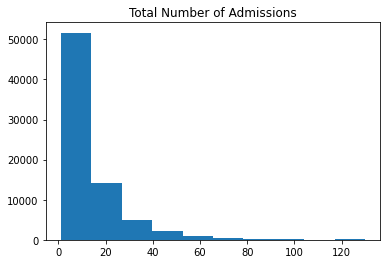

In [ ]:
plt.hist(full_feature["total_admissions"])
plt.title("Total Number of Admissions")
plt.show()

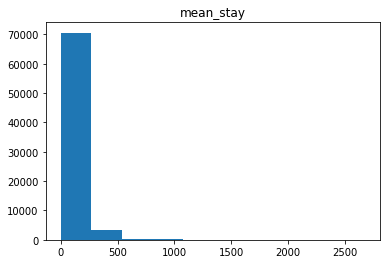

In [ ]:
plt.hist(full_feature["mean_stay"].sort_values())
plt.title("mean_stay")
plt.show()

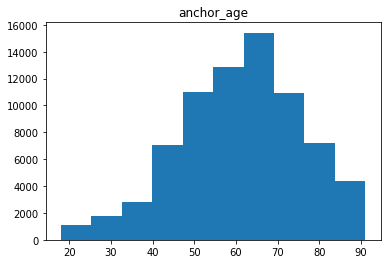

In [ ]:
plt.hist(full_feature["anchor_age"])
plt.title("anchor_age")
plt.show()

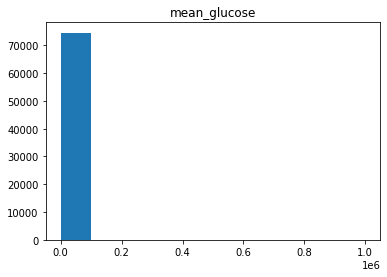

In [ ]:
# This graph contains outliers but is not used in our analysis.
plt.hist(full_feature["mean_glucose"])
plt.title("mean_glucose")
plt.show()

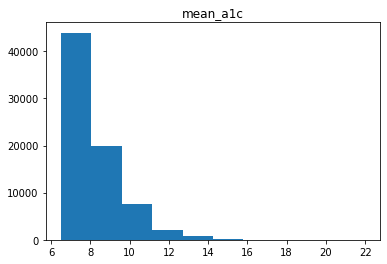

In [ ]:
plt.hist(full_feature["mean_a1c"])
plt.title("mean_a1c")
plt.show()

### Preliminary analysis on categorical features

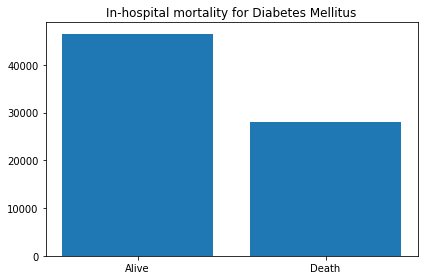

In [ ]:
plt.bar(["Alive", "Death"], full_feature["label"].value_counts())
plt.title("In-hospital mortality for Diabetes Mellitus")
plt.tight_layout()

plt.savefig("In-hospital mortality for Diabetes Mellitus.png")
plt.show()

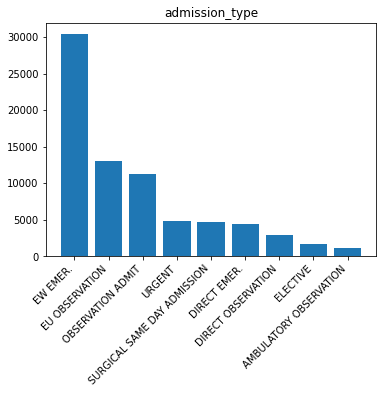

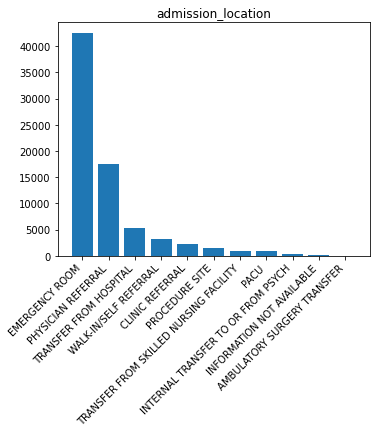

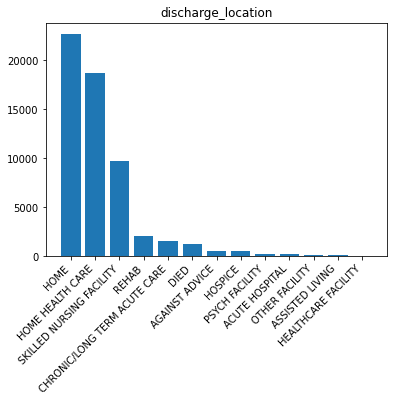

In [ ]:
plt.bar(full_feature["admission_type"].value_counts().index, full_feature["admission_type"].value_counts())
plt.title("admission_type")
plt.tight_layout()
plt.xticks(rotation = 45, ha = "right")
plt.show()

plt.bar(full_feature["admission_location"].value_counts().index, full_feature["admission_location"].value_counts())
plt.title("admission_location")
plt.tight_layout()
plt.xticks(rotation = 45, ha = "right")
plt.show()

# Died indicate death, so this feature dropped
plt.bar(full_feature["discharge_location"].value_counts().index, full_feature["discharge_location"].value_counts())
plt.title("discharge_location")
plt.tight_layout()
plt.xticks(rotation = 45, ha = "right")
plt.show()

#### Examine correlations betweeen features

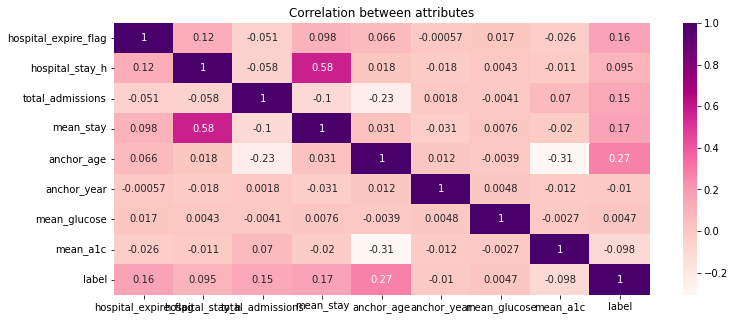

In [ ]:
dataset = full_feature[["admittime", "dischtime", "deathtime", "admission_type", "admission_location", "discharge_location",
       "insurance", "language", "marital_status", "race", "edregtime", "edouttime", "hospital_expire_flag", "hospital_stay_h", 
       "total_admissions", "mean_stay", "gender", "anchor_age", "anchor_year", "anchor_year_group", "dod", "mean_glucose", "mean_a1c",
       "label"]]
plt.subplots(figsize = (12, 5))
sns.heatmap(dataset.corr(), annot = True, cmap = "RdPu")
plt.title("Correlation between attributes")
plt.xticks(rotation = 0);

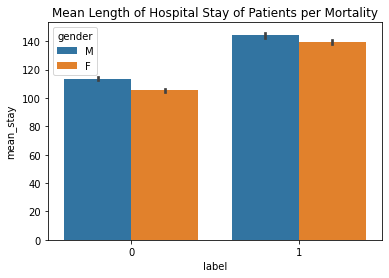

In [ ]:
ax = sns.barplot(data = dataset, x = "label", y = "mean_stay", hue = "gender")
ax.set_title("Mean Length of Hospital Stay of Patients per Mortality");
plt.show()

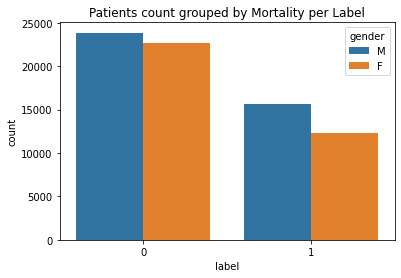

In [ ]:
ax = sns.countplot(data = dataset, x = "label", hue = "gender")
ax.set_title("Patients count grouped by Mortality per Label");
plt.show()

## Select the target features

In [ ]:
full_feature.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'hospital_stay_h', 'patient_id_x',
       'mean_stay', 'total_admissions', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod', 'patient_id_y', 'mean_glucose', 'mean_a1c',
       'label'],
      dtype='object')

In [ ]:
## Remove features that would not be used for the machine learning models, such as hospital_expire_flag

cleaned_feature = full_feature[["subject_id",
       "insurance", "language", "marital_status", "race",
       "total_admissions", "mean_stay", "gender", "anchor_age", "anchor_year",
       "anchor_year_group", "mean_glucose", "mean_a1c", "label"]]

In [ ]:
# Each patient may contain multiply admissions; keep all of those admissions
cleaned_feature = cleaned_feature.drop_duplicates()

In [ ]:
cleaned_feature["label"].value_counts() / cleaned_feature["label"].value_counts().sum()

0    0.733254
1    0.266746
Name: label, dtype: float64

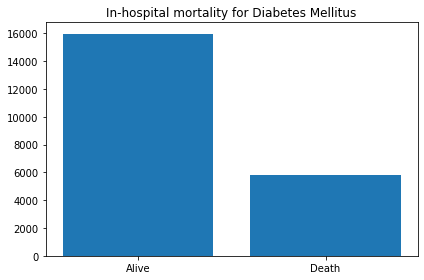

In [ ]:
plt.bar(["Alive", "Death"], cleaned_feature["label"].value_counts())
plt.title("In-hospital mortality for Diabetes Mellitus")
plt.tight_layout()

plt.savefig("In-hospital mortality for Diabetes Mellitus.png")
plt.show()

In [ ]:
cleaned_feature.to_csv("patient_data.csv", index = False)

## Split training features and labels

In [ ]:
X = cleaned_feature.drop(columns = ["subject_id", "label"])
col_name = X.columns
Y = cleaned_feature["label"]
X.head()

,insurance,language,marital_status,race,total_admissions,mean_stay,gender,anchor_age,anchor_year,anchor_year_group,mean_glucose,mean_a1c
0,Other,ENGLISH,None,WHITE,6,380.666667,M,63,2158,2008 - 2010,252.636364,7.25
6,Other,ENGLISH,None,UNKNOWN,1,210.000000,M,61,2136,2014 - 2016,253.833333,7.65
7,Medicare,ENGLISH,None,UNKNOWN,1,118.000000,M,77,2160,2017 - 2019,209.666667,7.80
8,Other,ENGLISH,None,UNKNOWN,8,126.625000,M,55,2171,2017 - 2019,242.100000,8.80
9,Other,ENGLISH,MARRIED,WHITE,8,126.625000,M,55,2171,2017 - 2019,242.100000,8.80


## Feature encoding

In [ ]:
# Ordinal encoding for all features
enc = OrdinalEncoder()
X = pd.DataFrame(enc.fit_transform(X), columns = X.columns)
X

,insurance,language,marital_status,race,total_admissions,mean_stay,gender,anchor_age,anchor_year,anchor_year_group,mean_glucose,mean_a1c
0,2.0,1.0,4.0,28.0,5.0,4383.0,1.0,45.0,48.0,0.0,1801.0,720.0
1,2.0,1.0,4.0,27.0,0.0,3638.0,1.0,43.0,26.0,2.0,1869.0,1265.0
2,1.0,1.0,4.0,27.0,0.0,2238.0,1.0,59.0,50.0,3.0,63.0,1454.0
3,2.0,1.0,4.0,27.0,7.0,2443.0,1.0,37.0,61.0,3.0,1152.0,2388.0
4,2.0,1.0,1.0,28.0,7.0,2443.0,1.0,37.0,61.0,3.0,1152.0,2388.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21791,1.0,0.0,0.0,18.0,0.0,3344.0,1.0,55.0,69.0,2.0,154.0,26.0
21792,2.0,1.0,0.0,28.0,1.0,3642.0,1.0,49.0,46.0,3.0,2760.0,1059.0
21793,2.0,1.0,0.0,28.0,0.0,3356.0,1.0,31.0,73.0,1.0,2207.0,3184.0
21794,2.0,1.0,0.0,31.0,0.0,1862.0,1.0,43.0,67.0,2.0,3790.0,2931.0


## Feature scaling

In [ ]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X

,insurance,language,marital_status,race,total_admissions,mean_stay,gender,anchor_age,anchor_year,anchor_year_group,mean_glucose,mean_a1c
0,0.950533,0.463980,2.772749,0.753275,-0.025119,1.884860,0.924139,0.083199,0.175430,-0.822369,-0.295053,-0.735112
1,0.950533,0.463980,2.772749,0.649672,-0.699549,1.318430,0.924139,-0.054154,-0.747018,1.065696,-0.257327,-0.241128
2,-0.559182,0.463980,2.772749,0.649672,-0.699549,0.253999,0.924139,1.044671,0.259289,2.009729,-1.259293,-0.069819
3,0.950533,0.463980,2.772749,0.649672,0.244652,0.409862,0.924139,-0.466214,0.720513,2.009729,-0.655117,0.776753
4,0.950533,0.463980,-0.605323,0.753275,0.244652,0.409862,0.924139,-0.466214,0.720513,2.009729,-0.655117,0.776753
...,...,...,...,...,...,...,...,...,...,...,...,...
21791,-0.559182,-2.155266,-1.731347,-0.282748,-0.699549,1.094900,0.924139,0.769965,1.055949,1.065696,-1.208806,-1.364150
21792,0.950533,0.463980,-1.731347,0.753275,-0.564663,1.321472,0.924139,0.357905,0.091571,2.009729,0.236999,-0.427845
21793,0.950533,0.463980,-1.731347,0.753275,-0.699549,1.104024,0.924139,-0.878273,1.223667,0.121664,-0.069805,1.498243
21794,0.950533,0.463980,-1.731347,1.064081,-0.699549,-0.031877,0.924139,-0.054154,0.972090,1.065696,0.808441,1.268925


## Split the training, testing and development sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

### Baseline model (KNN)

In [ ]:
knn = neighbors.KNeighborsClassifier(3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state = 0).fit(X_train, y_train)

### Random Forest

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

#### MLP: The performance is not as high as expected and requires further review.

In [ ]:
mlp = MLPClassifier(random_state = 0, max_iter = 1000).fit(X_train, y_train)

#### EBM: Explainable Boosting Machine


In [ ]:
ebm = ExplainableBoostingClassifier(random_state = 0)

## Parameter tuning

In [ ]:
# Logistic Regression
parameters = {"penalty": ["l1", "l2"]}
lr = LogisticRegression(random_state = 0)
lr = GridSearchCV(lr, parameters)
lr.fit(X_train, y_train)

print("Final parameters:", lr.cv_results_["params"][0])

Final parameters: {'penalty': 'l1', 'solver': 'saga'}


In [ ]:
# MLP
parameters = {"activation": ["logistic", "relu"]}
mlp = MLPClassifier(random_state = 0)
mlp = GridSearchCV(mlp, parameters)
mlp.fit(X_train, y_train)

print("Final parameters:",mlp.cv_results_["params"][0])

Final parameters: {'activation': 'logistic'}


In [ ]:
# Random Forest
parameters = {"max_features": ["sqrt", "log2"], "criterion": ["gini", "entropy"]}
rf = RandomForestClassifier(oob_score = True, random_state = 0)
rf = GridSearchCV(rf, parameters)
rf.fit(X_train, y_train)

print("Final parameters:", rf.cv_results_["params"][0])

Final parameters: {'criterion': 'gini', 'max_features': 'sqrt'}


### Fit the models


In [ ]:
lr = LogisticRegression(max_iter = 1000, random_state = 0, penalty = "l1", solver = "saga")
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='l1', random_state=0, solver='saga')

In [ ]:
mlp = MLPClassifier(random_state = 0, activation = "logistic", max_iter = 1000)
mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', max_iter=1000, random_state=0)

In [ ]:
rf = RandomForestClassifier(oob_score = True, random_state = 0, criterion = "gini", max_features = "sqrt")
rf.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=0)

In [ ]:
clf = ebm.fit(X_train, y_train)
clf

ExplainableBoostingClassifier(feature_names=['insurance', 'language',
                                             'marital_status', 'race',
                                             'total_admissions', 'mean_stay',
                                             'gender', 'anchor_age',
                                             'anchor_year', 'anchor_year_group',
                                             'mean_glucose', 'mean_a1c',
                                             'total_admissions x mean_a1c',
                                             'mean_stay x anchor_age',
                                             'total_admissions x mean_stay',
                                             'race x mean_glucose',
                                             'race x mean_stay',
                                             'total_admissions x anchor_age...
                                             'total_admissions x mean_glucose',
                                          

### Model evaluation

In [ ]:
print("The train accuracy for KNN is: {}".format(knn.score(X_train, y_train)))
print("The test accuracy for KNN is: {}\n".format(knn.score(X_test, y_test)))

print("The train accuracy for Logistic Regression is: {}".format(lr.score(X_train, y_train)))
print("The test accuracy for Logistic Regression is: {}\n".format(lr.score(X_test, y_test)))

print("The train accuracy for MLP is: {}".format(mlp.score(X_train, y_train)))
print("The test accuracy for MLP is: {}\n".format(mlp.score(X_test, y_test)))

print("The train accuracy for Random Forest is: {}".format(rf.score(X_train, y_train)))
print("The test accuracy for Random Forest is: {}\n".format(rf.score(X_test, y_test)))

print("The train accuracy for EBM is: {}".format(ebm.score(X_train, y_train)))
print("The test accuracy for EBM is: {}".format(ebm.score(X_test, y_test)))

The train accuracy for KNN is: 0.8696948841477403
The test accuracy for KNN is: 0.7559633027522936

The train accuracy for Logistic Regression is: 0.766173434273916
The test accuracy for Logistic Regression is: 0.7786697247706422

The train accuracy for MLP is: 0.8230672172516632
The test accuracy for MLP is: 0.7834862385321101

The train accuracy for Random Forest is: 1.0
The test accuracy for Random Forest is: 0.8841743119266054

The train accuracy for EBM is: 0.8034526267492544
The test accuracy for EBM is: 0.8036697247706422


In [ ]:
# Classification Report
print("Classification Report for KNN")
print(classification_report(y_test, knn.predict(X_test)))

print("Classification Report for Logistic Regression")
print(classification_report(y_test, lr.predict(X_test)))

print("Classification Report for MLP")
print(classification_report(y_test, mlp.predict(X_test)))

print("Classification Report for Random Forest")
print(classification_report(y_test, rf.predict(X_test)))

print("Classification Report for Explainable Boosting Machine")
print(classification_report(y_test, ebm.predict(X_test)))

Classification Report for KNN
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3188
           1       0.56      0.45      0.50      1172

    accuracy                           0.76      4360
   macro avg       0.68      0.66      0.67      4360
weighted avg       0.74      0.76      0.75      4360

Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      3188
           1       0.66      0.36      0.47      1172

    accuracy                           0.78      4360
   macro avg       0.73      0.65      0.66      4360
weighted avg       0.76      0.78      0.75      4360

Classification Report for MLP
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      3188
           1       0.63      0.48      0.55      1172

    accuracy                           0.78      4360
   macro avg       0.7

In [ ]:
# Balanced accuracy
print("Balanced accuracy for KNN:", balanced_accuracy_score(y_test, knn.predict(X_test)))
print("Balanced accuracy for Logistic Regression:", balanced_accuracy_score(y_test, lr.predict(X_test)))
print("Balanced accuracy for MLP:", balanced_accuracy_score(y_test, mlp.predict(X_test)))
print("Balanced accuracy for Random Forest:", balanced_accuracy_score(y_test, rf.predict(X_test)))
print("Balanced accuracy for Explainable Boosting Machine:", balanced_accuracy_score(y_test, ebm.predict(X_test)))

Balanced accuracy for KNN: 0.658844386586217
Balanced accuracy for Logistic Regression: 0.6460441459226365
Balanced accuracy for MLP: 0.6887260674628835
Balanced accuracy for Random Forest: 0.8085670025393862
Balanced accuracy for Explainable Boosting Machine: 0.6930854184420245


In [ ]:
# Matthews correlation coefficient
print("Matthews correlation coefficient for KNN:", matthews_corrcoef(y_test, knn.predict(X_test)))
print("Matthews correlation coefficient for Logistic Regression:", matthews_corrcoef(y_test, lr.predict(X_test)))
print("Matthews correlation coefficient for MLP:", matthews_corrcoef(y_test, mlp.predict(X_test)))
print("Matthews correlation coefficient for Random Forest:", matthews_corrcoef(y_test, rf.predict(X_test)))
print("Matthews correlation coefficient for Explainable Boosting Machine:", matthews_corrcoef(y_test, ebm.predict(X_test)))

Matthews correlation coefficient for KNN: 0.34196361664376296
Matthews correlation coefficient for Logistic Regression: 0.36710230376698677
Matthews correlation coefficient for MLP: 0.41243886486368886
Matthews correlation coefficient for Random Forest: 0.6921678456195637
Matthews correlation coefficient for Explainable Boosting Machine: 0.45412746244576185


### AUC and ROC curve

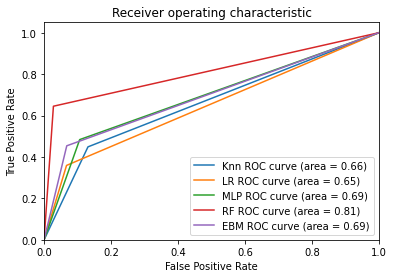

In [ ]:
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
for i in range(2):
    fpr_knn[i], tpr_knn[i], _ = roc_curve(y_test, knn.predict(X_test))
    roc_auc_knn[i] = auc(fpr_knn[i], tpr_knn[i])

fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()
for i in range(2):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test, lr.predict(X_test))
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()
for i in range(2):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test, mlp.predict(X_test))
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])

fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
for i in range(2):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test, rf.predict(X_test))
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

fpr_ebm = dict()
tpr_ebm = dict()
roc_auc_ebm = dict()
for i in range(2):
    fpr_ebm[i], tpr_ebm[i], _ = roc_curve(y_test, ebm.predict(X_test))
    roc_auc_ebm[i] = auc(fpr_ebm[i], tpr_ebm[i])

plt.figure()
plt.plot(fpr_knn[1], tpr_knn[1], label = "Knn ROC curve (area = %0.2f)" % roc_auc_score(y_test, knn.predict(X_test)))
plt.plot(fpr_lr[1], tpr_lr[1], label = "LR ROC curve (area = %0.2f)" % roc_auc_score(y_test, lr.predict(X_test)))
plt.plot(fpr_mlp[1], tpr_mlp[1], label = "MLP ROC curve (area = %0.2f)" % roc_auc_score(y_test, mlp.predict(X_test)))
plt.plot(fpr_rf[1], tpr_rf[1], label = "RF ROC curve (area = %0.2f)" % roc_auc_score(y_test, rf.predict(X_test)))
plt.plot(fpr_ebm[1], tpr_ebm[1], label = "EBM ROC curve (area = %0.2f)" % roc_auc_score(y_test, ebm.predict(X_test)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc = "lower right")
plt.savefig("AUC.png")
plt.show()

#### Visualise the global model behaviour with each feature

In [ ]:
ebm_global = ebm.explain_global()
show(ebm_global)

# Please run the code in jupyter notebook to see the actual plot  

### Visualise the local model behaviour with some unseen examples from the testing set

In [ ]:
set_visualize_provider(InlineProvider()) # plot the output here
ebm_local = ebm.explain_local(X_test[:15], y_test[:15])
show(ebm_local)
# Please run the code in jupyter notebook to see the actual plot  

Output hidden; open in https://colab.research.google.com to view.

## Final model: Random Forest
Feature analysis is performed on the Random Forest model.

In [ ]:
forest_importances = pd.Series(rf.feature_importances_, index = col_name).sort_values(ascending = True)
std = np.std([rf.feature_importances_ for tree in rf.estimators_], axis = 0)

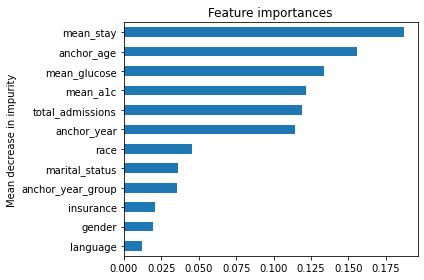

In [69]:
fig, ax = plt.subplots()
forest_importances.plot.barh(yerr = std, ax = ax)
ax.set_title("Feature importances")

ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("Featureimportances.png")
plt.show()

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
!jupyter nbconvert --to pdf --output "Code Appendix.pdf" --output-dir /content/drive/MyDrive/COMP90089/ /content/drive/MyDrive/COMP90089/Code_Appendix.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/COMP90089/Code_Appendix.ipynb to pdf
[NbConvertApp] Support files will be in Code Appendix_files/
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Making directory ./Code Appendix_files
[NbConvertApp] Writing 136040 byte